In [65]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
from torch.utils.data import DataLoader, TensorDataset

# To display YouTube videos
from IPython.display import YouTubeVideo

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cpu


In [66]:
# Load and preprocess the FashionMNIST datasets
transform = torchvision.transforms.ToTensor()  # Transform images to tensors

# Download and transform the FashionMNIST training data
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download and transform the FashionMNIST validation data
validation_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

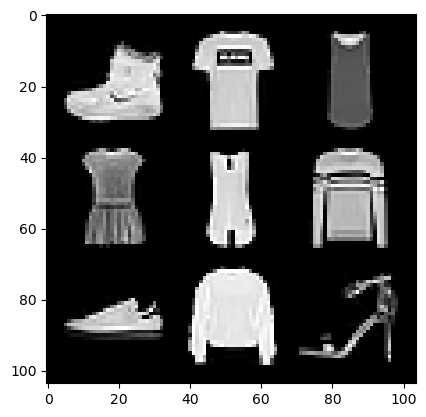

In [21]:
# Display a grid of sample images from the training dataset
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [67]:
# Normalize the dataset to range [0, 1]
X_train = training_data.data / 255.0
Y_train = training_data.targets
X_test = validation_data.data / 255.0
Y_test = validation_data.targets

# Prepare datasets and dataloaders
dataset_train = TensorDataset(X_train, Y_train)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataset_test = TensorDataset(X_test, Y_test)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

In [68]:
# Define the Vanilla RNN model for MNIST-like datasets
class VanillaRNN_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN_MNIST, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)  # RNN layer
        self.layer = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, images):
        # Initialize hidden state (zero-initialized)
        batch_size = images.size(0)
        self.hidden_state = torch.zeros(1, batch_size, self.hidden_size).to(images.device)
        
        # Reshape input to [seq_len, batch_size, input_size]
        images = images.permute(1, 0, 2)
        
        # RNN forward pass
        hidden_output, _ = self.rnn(images, self.hidden_state)
        
        # Use the last hidden state for classification
        out = self.layer(hidden_output[-1])
        return out

# Model hyperparameters
input_size = 28  # Each row of the image is treated as a time step
hidden_size = 40  # Number of RNN units
output_size = 10  # 10 output classes (FashionMNIST categories)
learning_rate = 0.0005  # Learning rate for the optimizer
epochs = 500  # Number of training epochs

# Initialize the model, loss function, and optimizer
model = VanillaRNN_MNIST(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

# Train the model
model.train()
for epoch in range(epochs):
    training_losses = []
    for batch in dataloader_train:
        # Get the batch data and move to the appropriate device
        x, y = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()  # Reset gradients
        
        # Forward pass
        pred = model(x)
        
        # Compute loss
        loss = criterion(pred, y)
        loss.backward()  # Backpropagation
        
        optimizer.step()  # Update parameters
        training_losses.append(loss.item())
    
    # Print training loss every 50 epochs
    if (epoch + 1) % 50 == 0:
        print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))


Finished Epoch 50 , training loss: 0.3865785571589653
Finished Epoch 100 , training loss: 0.34551134533973643
Finished Epoch 150 , training loss: 0.33268171806992497
Finished Epoch 200 , training loss: 0.32022599474008656
Finished Epoch 250 , training loss: 0.3191070821541332
Finished Epoch 300 , training loss: 0.3119993528116868
Finished Epoch 350 , training loss: 0.3183390108316438
Finished Epoch 400 , training loss: 0.30687985505694265
Finished Epoch 450 , training loss: 0.3289097618700853
Finished Epoch 500 , training loss: 0.3026955957129312


In [62]:
for epoch in range(epochs):
    training_losses = []
    for batch in dataloader_train:
        x, y = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    if (epoch+1)%50 == 0:
        print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

Finished Epoch 50 , training loss: 0.385319215386534
Finished Epoch 100 , training loss: 0.35597707378044563
Finished Epoch 150 , training loss: 0.33392373485955346
Finished Epoch 200 , training loss: 0.3238344383296936
Finished Epoch 250 , training loss: 0.32178162059772497
Finished Epoch 300 , training loss: 0.3139368691392291
Finished Epoch 350 , training loss: 0.3150408326435699
Finished Epoch 400 , training loss: 0.30458875532661167
Finished Epoch 450 , training loss: 0.3064155020534611
Finished Epoch 500 , training loss: 0.30960593768147265


In [ ]:
# Evaluate the model on the training set
with torch.no_grad():
    model.eval()
    num_correct = 0
    total_samples = 0
    for batch in dataloader_train:
        x, y = batch[0].to(device), batch[1].to(device)
        pred = model(x)
        pred_label = torch.argmax(pred, axis=1)
        num_correct += (y == pred_label).sum().item()
        total_samples += y.size(0)
    print("Final Accuracy on Training Set: ", num_correct / total_samples)
    model.train()  # Set the model back to training mode

Final Accuracy on Training Set:  0.88995


In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    num_correct = 0
    total_samples = 0
    for batch in dataloader_test:
        x, y = batch[0].to(device), batch[1].to(device)
        pred = model(x)
        pred_label = torch.argmax(pred, axis=1)
        num_correct += (y == pred_label).sum().item()
        total_samples += y.size(0)
    print("Final Accuracy on Testing Set: ", num_correct / total_samples)

Final Accuracy on Testing Set:  0.8637
